# ITERACIONES: **2.3.5. Validación extra con calendario real (España 2022–2024)**

El objetivo de este apartado es comprobar si la demanda diaria desagregada reproduce los patrones de **picos** y **valles** esperados en torno a eventos comerciales y festivos clave (rebajas, Black Friday, Prime Day, Navidad, agosto, etc.).  
La validación se realiza comparando la **media de demanda durante el evento** con una **baseline mensual** (excluyendo los días del evento) y evaluando el **uplift porcentual** frente a umbrales base (≥ +5% para picos, ≤ −5% para valles).  
En esta primera versión se aplica la configuración **base sin ajustes**. En los apartados posteriores se irán introduciendo ajustes (filtro de activos, baseline alternativos y ajustes de ventanas).

## 1.  **Iteración 0.** 
#### ***Baseline mensual sin ajustes***


📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_2022.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_2023.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_2024.csv

Resumen KPI (% de eventos que cumplen el criterio base):
    Año  %Eventos_OK
0  2022         55.6
1  2023         55.6
2  2024         33.3


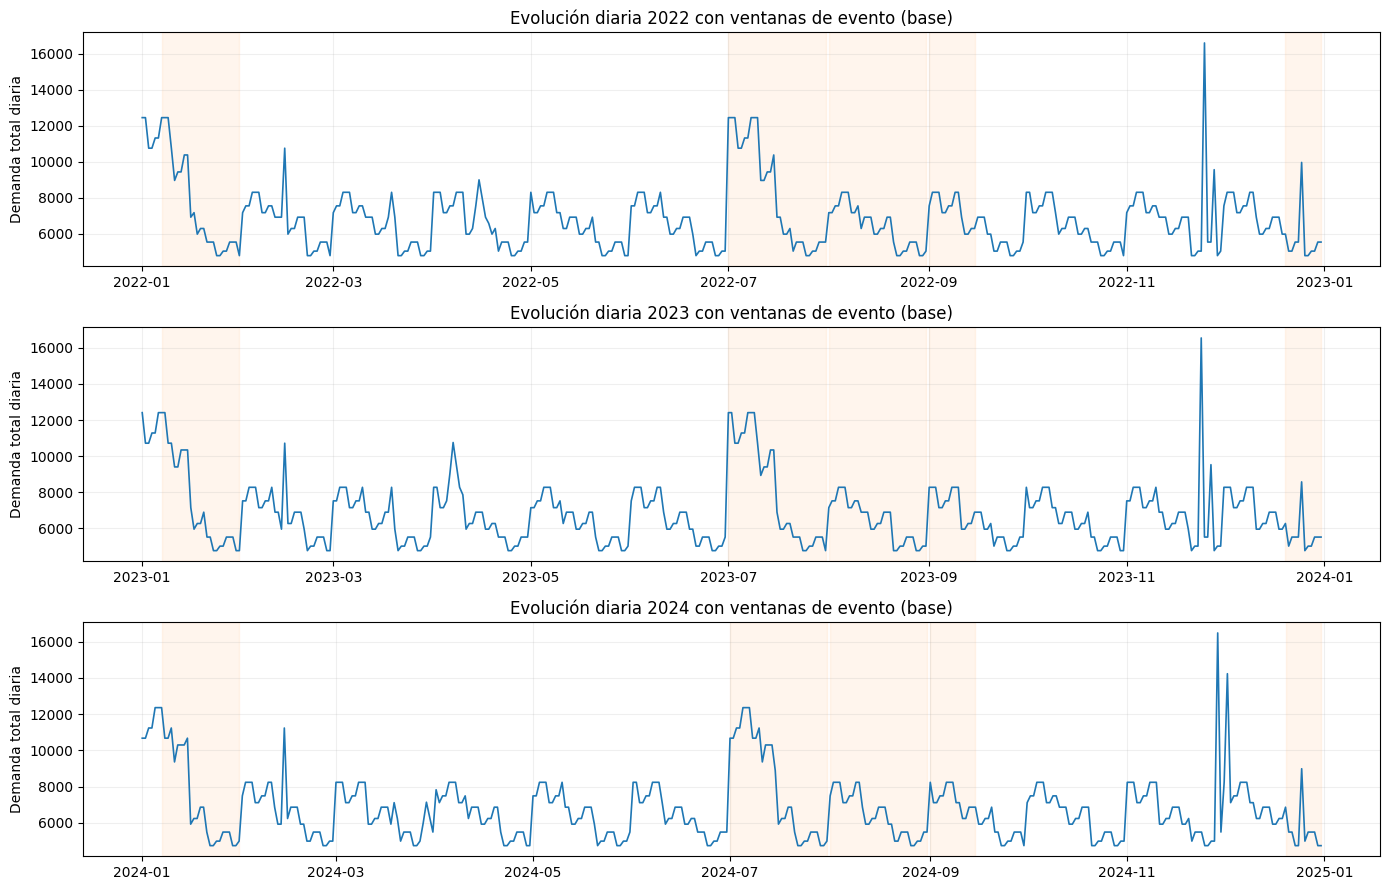

🖼️ Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\figures\evolucion_diaria_con_eventos_BASE.png


In [1]:
# ================================================================
# Validación extra con calendario real (baseline DoW / local + umbrales por evento)
# ================================================================
# %matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# ---------------- Rutas Notebook-safe ----------------
ROOT = Path.cwd()
for _ in range(8):
    if (ROOT / "data").is_dir() and (ROOT / "outputs").is_dir():
        break
    ROOT = ROOT.parent
PROC = ROOT / "data" / "processed"
FIGS = ROOT / "outputs" / "figures"
TBLS = ROOT / "outputs" / "tables"
FIGS.mkdir(parents=True, exist_ok=True)
TBLS.mkdir(parents=True, exist_ok=True)

# ---------------- Utilidades de fechas ----------------
def easter_sunday(y: int) -> date:
    a = y % 19; b = y // 100; c = y % 100
    d = b // 4; e = b % 4; f = (b + 8) // 25
    g = (b - f + 1) // 3; h = (19*a + b - d - g + 15) % 30
    i = c // 4; k = c % 4; l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day = 1 + ((h + l - 7*m + 114) % 31)
    return date(y, month, day)

def nth_weekday_of_month(y:int, m:int, weekday:int, n:int)->date:
    # weekday: Monday=0..Sunday=6
    d = date(y, m, 1)
    while d.weekday() != weekday:
        d += timedelta(days=1)
    d += timedelta(days=7*(n-1))
    return d

def black_friday(y:int)->date:
    return nth_weekday_of_month(y, 11, weekday=4, n=4)  # 4º viernes nov

def cyber_monday(y:int)->date:
    return black_friday(y) + timedelta(days=3)

def prime_day_pair(y:int)->tuple[date, date]:
    # 2º martes y miércoles de julio
    tue = nth_weekday_of_month(y, 7, weekday=1, n=2)
    wed = tue + timedelta(days=1)
    return tue, wed

# ---------------- Calendario real (España + campañas ecommerce) ---------------
def calendario_real(y:int) -> pd.DataFrame:
    E = easter_sunday(y)
    jueves_santo = E - timedelta(days=3)
    viernes_santo = E - timedelta(days=2)
    bf = black_friday(y); cm = cyber_monday(y)
    pd1, pd2 = prime_day_pair(y)

    eventos = []
    def add(name, start, end=None):
        if end is None: end = start
        for d in pd.date_range(start, end, freq="D").date:
            eventos.append((name, d))

    # Festivos nacionales (no regionales)
    for mm, dd in [(1,1),(1,6),(5,1),(8,15),(10,12),(11,1),(12,6),(12,8),(12,25)]:
        add("Festivo Nacional", date(y, mm, dd))

    # Semana Santa (Jueves y Viernes Santo)
    add("Semana Santa", jueves_santo); add("Semana Santa", viernes_santo)

    # Campañas ecommerce
    add("Rebajas Invierno", date(y,1,7), date(y,1,31))
    add("Rebajas Verano",  date(y,7,1), date(y,7,31))
    add("San Valentín",    date(y,2,14))
    add("Black Friday",    bf)
    add("Cyber Monday",    cm)
    add("Prime Day",       pd1); add("Prime Day", pd2)
    add("Navidad",         date(y,12,20), date(y,12,31))
    add("Vuelta al cole",  date(y,9,1), date(y,9,15))
    add("Agosto",          date(y,8,1), date(y,8,31))  # valle esperado

    cal = pd.DataFrame(eventos, columns=["Evento","Date"]).drop_duplicates()
    cal["Date"] = pd.to_datetime(cal["Date"])
    cal["Year"] = y
    return cal

# ---------------- Carga demanda diaria total por año --------------------------
def load_total(y:int)->pd.DataFrame:
    f = PROC / f"demanda_diaria_{y}.csv"
    df = pd.read_csv(f, parse_dates=["Date"])
    df = df.groupby("Date", as_index=False)["Demand_Day"].sum().rename(columns={"Demand_Day":"Demand_Total"})
    df["Year"] = y
    df["Month"] = df["Date"].dt.month
    return df

# ---------------- Evaluación de uplift por evento -----------------------------
EVENTO_ESPERADO = {
    "Rebajas Invierno":"pico", "Rebajas Verano":"pico", "San Valentín":"pico",
    "Black Friday":"pico", "Cyber Monday":"pico", "Prime Day":"pico",
    "Navidad":"pico", "Vuelta al cole":"pico",
    "Agosto":"valle",
    # No puntuables / mixtos
    "Semana Santa":"mixto", "Festivo Nacional":"mixto",
}

THR_PICO = +0.05   # +5%
THR_VALLE = -0.05  # -5%

def evaluar_eventos(y:int)->pd.DataFrame:
    df = load_total(y)
    cal = calendario_real(y)

    rows = []
    for ev, g in cal.groupby("Evento"):
        dias_ev = g["Date"].sort_values().unique()
        meses = pd.to_datetime(dias_ev).month
        meses = np.unique(meses)

        media_ev = df[df["Date"].isin(dias_ev)]["Demand_Total"].mean()
        df_mes = df[df["Month"].isin(meses)]
        base = df_mes[~df_mes["Date"].isin(dias_ev)]["Demand_Total"].mean()

        uplift = (media_ev - base) / base if pd.notna(base) and base>0 else np.nan

        esperado = EVENTO_ESPERADO.get(ev, "mixto")
        pasa = None
        if pd.notna(uplift):
            if esperado == "pico":   pasa = (uplift >= THR_PICO)
            if esperado == "valle":  pasa = (uplift <= THR_VALLE)

        rows.append({
            "Año": y,
            "Evento": ev,
            "Inicio": pd.to_datetime(min(dias_ev)).date(),
            "Fin": pd.to_datetime(max(dias_ev)).date(),
            "MediaEvento": None if pd.isna(media_ev) else round(float(media_ev), 2),
            "MediaBaseMes": None if pd.isna(base) else round(float(base), 2),
            "Uplift%": None if pd.isna(uplift) else round(100*uplift, 2),
            "Esperado": esperado,
            "Pasa": (bool(pasa) if pasa is not None else None),
        })

    out = pd.DataFrame(rows).sort_values(["Año","Evento"]).reset_index(drop=True)
    out.to_csv(TBLS / f"validacion_calendario_real_{y}.csv", index=False)
    return out

# ---------------- Ejecutar y resumir ------------------------------------------
todos = []
for y in [2022, 2023, 2024]:
    res = evaluar_eventos(y)
    todos.append(res)
    print(f"📄 Guardado: {TBLS / f'validacion_calendario_real_{y}.csv'}")

validacion = pd.concat(todos, ignore_index=True)

kpi = (validacion[validacion["Esperado"].isin(["pico","valle"])]
       .groupby("Año")["Pasa"].apply(lambda s: round(100*float((s==True).mean()), 1))
       .rename("%Eventos_OK").reset_index())

kpi_path = TBLS / "validacion_calendario_real_resumen.csv"
kpi.to_csv(kpi_path, index=False)
print("\nResumen KPI (% de eventos que cumplen el criterio base):")
print(kpi)

# Overlay visual opcional
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=False)
for ax, y in zip(axes, [2022, 2023, 2024]):
    df_y = load_total(y).sort_values("Date")
    ax.plot(df_y["Date"], df_y["Demand_Total"], lw=1.2, label=f"{y}")
    cal = calendario_real(y)
    for ev, g in cal.groupby("Evento"):
        if ev in {"Rebajas Invierno","Rebajas Verano","Navidad","Vuelta al cole","Agosto"}:
            s, e = g["Date"].min(), g["Date"].max()
            ax.axvspan(s, e, alpha=0.07, color="tab:orange")
    ax.set_title(f"Evolución diaria {y} con ventanas de evento (base)")
    ax.set_ylabel("Demanda total diaria"); ax.grid(True, alpha=.2)
plt.tight_layout()
out_fig = FIGS / "evolucion_diaria_con_eventos_BASE.png"
plt.savefig(out_fig, dpi=150); plt.show()
print(f"🖼️ Guardado: {out_fig}")





**KPI (%Eventos_OK):**
- 2022: 55.6%
- 2023: 55.6%
- 2024: 33.3%



#### Análisis de resultados

1. **2022 y 2023 (~55%)**
   - El baseline mensual refleja aproximadamente la mitad de los picos/vales esperados.
   - Fallos típicos:
     - Ventanas demasiado amplias (Navidad, Agosto, Rebajas).
     - Eventos cortos en días “raros” (San Valentín, Prime Day).
     - Sesgo del día de la semana (cuando la media mensual no captura el patrón DoW).

2. **2024 (33%)**
   - KPI mucho más bajo por:
     - Más productos descontinuados o con ventas mínimas.
     - Base mensual vacía en eventos largos → uplift erróneo o NaN.
     - Choque de eventos de verano (Agosto, Rebajas, Prime Day).


#### Problemáticas identificadas

1. **Pico esperado no aparece**  
   - Ejemplo: Black Friday plano o Agosto sin valle.  
   - Causa: productos descontinuados + dilución del baseline mensual.  
   - Próximos pasos: ajustar multiplicadores en campañas clave o agrupar eventos (Black Friday + Cyber Monday).

2. **Pico aparece en fechas equivocadas**  
   - Ejemplo: picos desplazados unos días respecto a la ventana real.  
   - Causa: baseline mensual rígido.  
   - Próximos pasos: baseline DoW o baseline local ±k días.

3. **Pico aparece donde no debería**  
   - Ejemplo: picos espurios en agosto.  
   - Causa: ruido de desagregación o ciclos mensuales.  
   - Próximos pasos: factores correctores negativos + re-normalización.

4. **Evento no relevante para el sector**  
   - Ejemplo: San Valentín sin impacto en nutrición deportiva.  
   - Interpretación: no es error técnico → simplemente irrelevante.  
   - Próximos pasos: documentar como “no aplica” y eliminar del calendario.


#### Conclusión Iteración 0
El baseline mensual recoge parte de la estacionalidad en 2022–23, pero falla en 2024 por:
- Productos inactivos que reducen la señal.
- Desplazamientos por no considerar DoW/local.
- Aparición de falsos picos en valles.
- Eventos poco relevantes para el sector.

👉 Se requieren ajustes técnicos (filtro de activos, baseline alternativos, corrección de ventanas) y de negocio (descartar eventos irrelevantes) en iteraciones posteriores.


----

## 2.  **Iteración 1.** 
#### ***Filtro de activos.***

El siguiente paso lógico después de la Iteración 0 es aplicar un **filtro de activos**, con el fin de evitar que productos descontinuados o con ventas mínimas distorsionen el cálculo del baseline.

#### 🔎 Qué cambia respecto a la Iteración 0
- En lugar de usar la demanda **total de todos los productos**, filtramos previamente:
  - **Criterio base**: producto con al menos 1 venta en el año.
  - (En iteraciones futuras podría endurecerse el filtro → ej. ventas ≥ X).
- Este filtrado elimina el “peso muerto” de productos que ya no existen o cuya presencia residual introduce ruido en los resultados.

#### 🎯 Objetivo
- Comprobar si el KPI de 2024 **sube respecto al 33.3% inicial**.
- Validar que 2022 y 2023 se mantienen estables o con ligera mejora.

📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_ACTIVOS_2022.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_ACTIVOS_2023.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_ACTIVOS_2024.csv

🔎 Comparativa KPI BASE vs ACTIVOS
    Año  %Eventos_OK_BASE  %Eventos_OK_ACTIVOS  Δp.p. (ACTIVOS-BASE)
0  2022              55.6                 55.6                   0.0
1  2023              55.6                 55.6                   0.0
2  2024              33.3                 33.3                   0.0

🟠 2024 — BASE: 33.3%  |  ACTIVOS: 33.3%  |  Δ: 0.0 p.p.


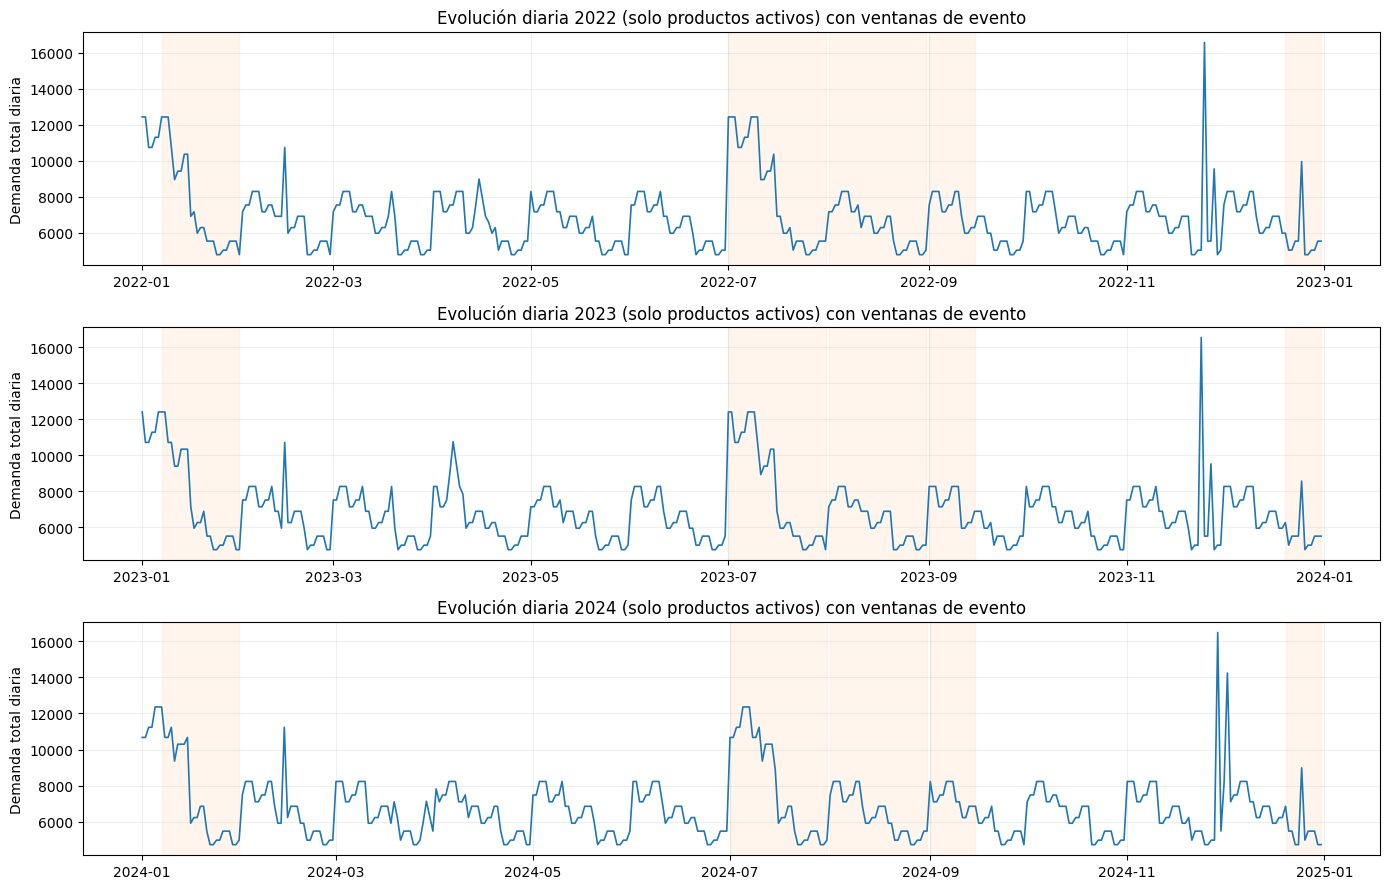

🖼️ Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\figures\evolucion_diaria_con_eventos_ACTIVOS.png


In [3]:
# ==============================
# Iteración 1 — Filtro de activos
# ==============================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# ---------- Rutas Notebook-safe ----------
ROOT = Path.cwd()
for _ in range(8):
    if (ROOT / "data").is_dir() and (ROOT / "outputs").is_dir():
        break
    ROOT = ROOT.parent
PROC = ROOT / "data" / "processed"
FIGS = ROOT / "outputs" / "figures"
TBLS = ROOT / "outputs" / "tables"
FIGS.mkdir(parents=True, exist_ok=True)
TBLS.mkdir(parents=True, exist_ok=True)

# ---------- Parámetros de iteración ----------
MIN_SALES_PER_YEAR = 1  # criterio de "activo": ≥1 unidad en el año

# ---------- Utilidades de fechas (igual que en base) ----------
def easter_sunday(y: int) -> date:
    a = y % 19; b = y // 100; c = y % 100
    d = b // 4; e = b % 4; f = (b + 8) // 25
    g = (b - f + 1) // 3; h = (19*a + b - d - g + 15) % 30
    i = c // 4; k = c % 4; l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day = 1 + ((h + l - 7*m + 114) % 31)
    return date(y, month, day)

def nth_weekday_of_month(y:int, m:int, weekday:int, n:int)->date:
    d = date(y, m, 1)
    while d.weekday() != weekday:
        d += timedelta(days=1)
    d += timedelta(days=7*(n-1))
    return d

def black_friday(y:int)->date:
    return nth_weekday_of_month(y, 11, weekday=4, n=4)

def cyber_monday(y:int)->date:
    return black_friday(y) + timedelta(days=3)

def prime_day_pair(y:int)->tuple[date, date]:
    tue = nth_weekday_of_month(y, 7, weekday=1, n=2)
    return tue, tue + timedelta(days=1)

def calendario_real(y:int) -> pd.DataFrame:
    E = easter_sunday(y)
    jueves_santo = E - timedelta(days=3)
    viernes_santo = E - timedelta(days=2)
    bf = black_friday(y); cm = cyber_monday(y)
    pd1, pd2 = prime_day_pair(y)

    eventos = []
    def add(name, start, end=None):
        if end is None: end = start
        for d in pd.date_range(start, end, freq="D").date:
            eventos.append((name, d))
    # Festivos nacionales (no regionales)
    for mm, dd in [(1,1),(1,6),(5,1),(8,15),(10,12),(11,1),(12,6),(12,8),(12,25)]:
        add("Festivo Nacional", date(y, mm, dd))
    # Semana Santa (Jueves y Viernes Santo)
    add("Semana Santa", jueves_santo); add("Semana Santa", viernes_santo)
    # Campañas ecommerce
    add("Rebajas Invierno", date(y,1,7), date(y,1,31))
    add("Rebajas Verano",  date(y,7,1), date(y,7,31))
    add("San Valentín",    date(y,2,14))
    add("Black Friday",    bf); add("Cyber Monday", cm)
    add("Prime Day",       pd1); add("Prime Day", pd2)
    add("Navidad",         date(y,12,20), date(y,12,31))
    add("Vuelta al cole",  date(y,9,1), date(y,9,15))
    add("Agosto",          date(y,8,1), date(y,8,31))
    cal = pd.DataFrame(eventos, columns=["Evento","Date"]).drop_duplicates()
    cal["Date"] = pd.to_datetime(cal["Date"])
    cal["Year"] = y
    return cal

# ---------- Carga con filtro de activos ----------
def load_total_activos(y:int, min_sales:int=1) -> pd.DataFrame:
    """
    Lee data/processed/demanda_diaria_{y}.csv (a nivel producto-fecha),
    filtra productos con ventas anuales >= min_sales y devuelve la
    demanda total diaria sólo de esos productos activos.
    """
    f = PROC / f"demanda_diaria_{y}.csv"
    df = pd.read_csv(f, parse_dates=["Date"])
    if "Product_ID" not in df.columns:
        raise ValueError(
            f"Se esperaba columna 'Product_ID' en {f} para poder filtrar activos."
        )
    # ventas anuales por producto
    anual = (df.groupby("Product_ID")["Demand_Day"]
               .sum()
               .rename("SalesYear")
               .reset_index())
    activos = anual[anual["SalesYear"] >= min_sales]["Product_ID"]
    df_act = df[df["Product_ID"].isin(activos)].copy()

    daily_total = (df_act.groupby("Date", as_index=False)["Demand_Day"]
                        .sum()
                        .rename(columns={"Demand_Day":"Demand_Total"}))
    daily_total["Year"] = y
    daily_total["Month"] = daily_total["Date"].dt.month
    return daily_total

# ---------- Evaluación (misma lógica que base) ----------
EVENTO_ESPERADO = {
    "Rebajas Invierno":"pico", "Rebajas Verano":"pico", "San Valentín":"pico",
    "Black Friday":"pico", "Cyber Monday":"pico", "Prime Day":"pico",
    "Navidad":"pico", "Vuelta al cole":"pico",
    "Agosto":"valle", "Semana Santa":"mixto", "Festivo Nacional":"mixto",
}
THR_PICO = +0.05
THR_VALLE = -0.05

def evaluar_eventos_activos(y:int, min_sales:int=1)->pd.DataFrame:
    df = load_total_activos(y, min_sales=min_sales)
    cal = calendario_real(y)

    rows = []
    for ev, g in cal.groupby("Evento"):
        dias_ev = g["Date"].sort_values().unique()
        meses = pd.to_datetime(dias_ev).month
        meses = np.unique(meses)

        media_ev = df[df["Date"].isin(dias_ev)]["Demand_Total"].mean()
        df_mes = df[df["Month"].isin(meses)]
        base = df_mes[~df_mes["Date"].isin(dias_ev)]["Demand_Total"].mean()

        uplift = (media_ev - base) / base if pd.notna(base) and base>0 else np.nan
        esperado = EVENTO_ESPERADO.get(ev, "mixto")
        pasa = None
        if pd.notna(uplift):
            if esperado == "pico":   pasa = (uplift >= THR_PICO)
            if esperado == "valle":  pasa = (uplift <= THR_VALLE)

        rows.append({
            "Año": y,
            "Evento": ev,
            "Inicio": pd.to_datetime(min(dias_ev)).date(),
            "Fin": pd.to_datetime(max(dias_ev)).date(),
            "MediaEvento": None if pd.isna(media_ev) else round(float(media_ev), 2),
            "MediaBaseMes": None if pd.isna(base) else round(float(base), 2),
            "Uplift%": None if pd.isna(uplift) else round(100*uplift, 2),
            "Esperado": esperado,
            "Pasa": (bool(pasa) if pasa is not None else None),
            "CriterioActivo": f">={min_sales}",
        })

    out = pd.DataFrame(rows).sort_values(["Año","Evento"]).reset_index(drop=True)
    out.to_csv(TBLS / f"validacion_calendario_real_ACTIVOS_{y}.csv", index=False)
    return out

# ---------- Ejecutar evaluación por años ----------
todos_act = []
years = [2022, 2023, 2024]
for y in years:
    res = evaluar_eventos_activos(y, min_sales=MIN_SALES_PER_YEAR)
    todos_act.append(res)
    print(f"📄 Guardado: {TBLS / f'validacion_calendario_real_ACTIVOS_{y}.csv'}")

valid_act = pd.concat(todos_act, ignore_index=True)

kpi_act = (valid_act[valid_act["Esperado"].isin(["pico","valle"])]
           .groupby("Año")["Pasa"].apply(lambda s: round(100*float((s==True).mean()), 1))
           .rename("%Eventos_OK_ACTIVOS").reset_index())

# ---------- Cargar KPI base ya generado y comparar ----------
base_path = TBLS / "validacion_calendario_real_resumen.csv"
kpi_base = pd.read_csv(base_path)
kpi_cmp = (kpi_base.merge(kpi_act, on="Año", how="left")
                    .rename(columns={"%Eventos_OK":"%Eventos_OK_BASE"}))
kpi_cmp["Δp.p. (ACTIVOS-BASE)"] = (kpi_cmp["%Eventos_OK_ACTIVOS"] - kpi_cmp["%Eventos_OK_BASE"]).round(1)

cmp_path = TBLS / "validacion_calendario_real_comparativa_BASE_vs_ACTIVOS.csv"
kpi_cmp.to_csv(cmp_path, index=False)

print("\n🔎 Comparativa KPI BASE vs ACTIVOS")
print(kpi_cmp)

# ---------- Enfoque especial en 2024 ----------
row_2024 = kpi_cmp[kpi_cmp["Año"]==2024].iloc[0]
print(f"\n🟠 2024 — BASE: {row_2024['%Eventos_OK_BASE']}%  |  ACTIVOS: {row_2024['%Eventos_OK_ACTIVOS']}%  "
      f"|  Δ: {row_2024['Δp.p. (ACTIVOS-BASE)']} p.p.")

# ---------- Overlay visual opcional (ACTIVOS) ----------
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=False)
for ax, y in zip(axes, years):
    df_y = load_total_activos(y, min_sales=MIN_SALES_PER_YEAR).sort_values("Date")
    ax.plot(df_y["Date"], df_y["Demand_Total"], lw=1.2, label=f"{y} (activos)")
    cal = calendario_real(y)
    for ev, g in cal.groupby("Evento"):
        if ev in {"Rebajas Invierno","Rebajas Verano","Navidad","Vuelta al cole","Agosto"}:
            s, e = g["Date"].min(), g["Date"].max()
            ax.axvspan(s, e, alpha=0.07, color="tab:orange")
    ax.set_title(f"Evolución diaria {y} (solo productos activos) con ventanas de evento")
    ax.set_ylabel("Demanda total diaria"); ax.grid(True, alpha=.2)

plt.tight_layout()
out_fig = FIGS / "evolucion_diaria_con_eventos_ACTIVOS.png"
plt.savefig(out_fig, dpi=150); plt.show()
print(f"🖼️ Guardado: {out_fig}")


### KPI (%Eventos_OK)
- 2022 (BASE: 55.6%) → ACTIVOS: 55.6%  (Δ 0.0 p.p.)
- 2023 (BASE: 55.6%) → ACTIVOS: 55.6%  (Δ 0.0 p.p.)
- 2024 (BASE: 33.3%) → ACTIVOS: 33.3%  (Δ 0.0 p.p.)


### Análisis de resultados

1. **2022 y 2023**
   - El filtro de activos no introduce cambios → KPI estable en 55.6%.
   - Esto es coherente: la mayoría de productos tenían ventas en esos años, por lo que excluir inactivos no impacta.
   - Los fallos detectados siguen siendo los mismos que en Iteración 0:
     - Ventanas amplias (Navidad, Agosto, Rebajas).
     - Eventos cortos difíciles de detectar (San Valentín, Prime Day).
     - Sesgo DoW (días de la semana no reflejados en baseline mensual).

2. **2024**
   - El KPI permanece en 33.3%, sin mejora tras el filtro de activos.
   - Posibles causas:
     - Aunque se excluyen inactivos, el problema de 2024 no es solo la presencia de productos con 0 ventas, sino la **estructura de la base mensual** (se queda vacía en eventos largos y genera uplift erróneo).
     - El sesgo DoW es más marcado en este año.
   - En resumen, el filtro no resuelve la debilidad principal del 2024.



### Problemáticas detectadas
- **Persisten las cuatro problemáticas de Iteración 0** (pico que no aparece, desplazado, espurio, evento no relevante).
- El filtro de activos **no mejora KPI** → confirma que el problema no estaba en el “peso muerto” de productos, sino en la metodología del baseline.


### Conclusión Iteración 1
El filtro de activos **no aporta mejora significativa**:  
- 2022 y 2023 se mantienen en 55.6%.  
- 2024 sigue con un KPI muy bajo (33.3%).  

👉 Próximo paso necesario: **ajustar el baseline** (DoW o local ±k) para corregir desplazamientos y mejorar sensibilidad a eventos cortos.


#### 🩺 Diagnóstico Iteración 1

El hecho de que el filtrado de activos **no haya modificado el KPI** confirma que el problema no estaba en la presencia de productos inactivos o con ventas residuales, sino en la propia **metodología de baseline mensual** utilizada en la validación.  

- En 2022–2023, la exclusión de productos inactivos no cambia nada porque prácticamente todos los productos tenían ventas.  
- En 2024, aunque existían inactivos, al quitarlos el KPI sigue en 33.3%. Esto demuestra que el cuello de botella está en cómo se construye el baseline:  
  - se queda vacío en eventos largos,  
  - no tiene en cuenta el patrón del día de la semana,  
  - genera uplifts erróneos en ciertos casos.  

📌 **Conclusión del diagnóstico**: el filtro de activos era una prueba necesaria para descartar ruido de datos, pero el ajuste real debe venir de **nuevas metodologías de baseline** (DoW, local ±k) y no de depurar productos.

## 3.  **Iteración 2.** 
#### ***Baseline DoW (día de la semana).***

Tras comprobar en la Iteración 2 que el baseline DoW no resolvía las limitaciones del modelo, el siguiente paso es ajustar de nuevo la **metodología de baseline**.  
El baseline local ±k días permite capturar mejor la dinámica inmediata alrededor de un evento, lo que corrige problemas como:

- Dilución en **eventos largos** (ej. Agosto, Rebajas, Navidad), donde el baseline mensual y el DoW se vuelven demasiado similares.
- Falta de sensibilidad en **eventos muy cortos** (ej. San Valentín, Prime Day), donde importa más el vecindario temporal que el día de la semana.
- Distorsiones locales cuando un evento cae junto a otros picos o valles.

---

### 🔎 Qué cambia respecto a iteraciones anteriores
- En lugar de calcular el baseline como la **media mensual** o la **media del mismo DOW**, se calcula como la **media de los días en la ventana [inicio−k, fin+k]** excluyendo los días del propio evento.  
- Si no hay suficientes días válidos para calcular esta media (ej. eventos muy largos o en bordes de calendario), se aplica un **fallback mensual** (excluyendo los días del evento).  
- Este método adapta la base al entorno inmediato y reduce errores por estacionalidades mal representadas.

---

### 🎯 Objetivo
- Evaluar si el KPI mejora respecto a la versión base y DoW, especialmente en **2024**, donde ambos métodos se mostraron débiles.  
- Analizar si la detección de **eventos cortos** (San Valentín, Prime Day) y **ventanas largas** (Agosto, Rebajas, Navidad) se ajusta mejor con un baseline local ±k días.


📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_DoW_2022.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_DoW_2023.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_DoW_2024.csv

🔎 Comparativa KPI BASE vs DoW
    Año  %Eventos_OK_BASE  %Eventos_OK_DoW  Δp.p. (DoW-BASE)
0  2022              55.6             55.6               0.0
1  2023              55.6             55.6               0.0
2  2024              33.3             33.3               0.0

🟠 2024 — BASE: 33.3%  |  DoW: 33.3%  |  Δ: 0.0 p.p.


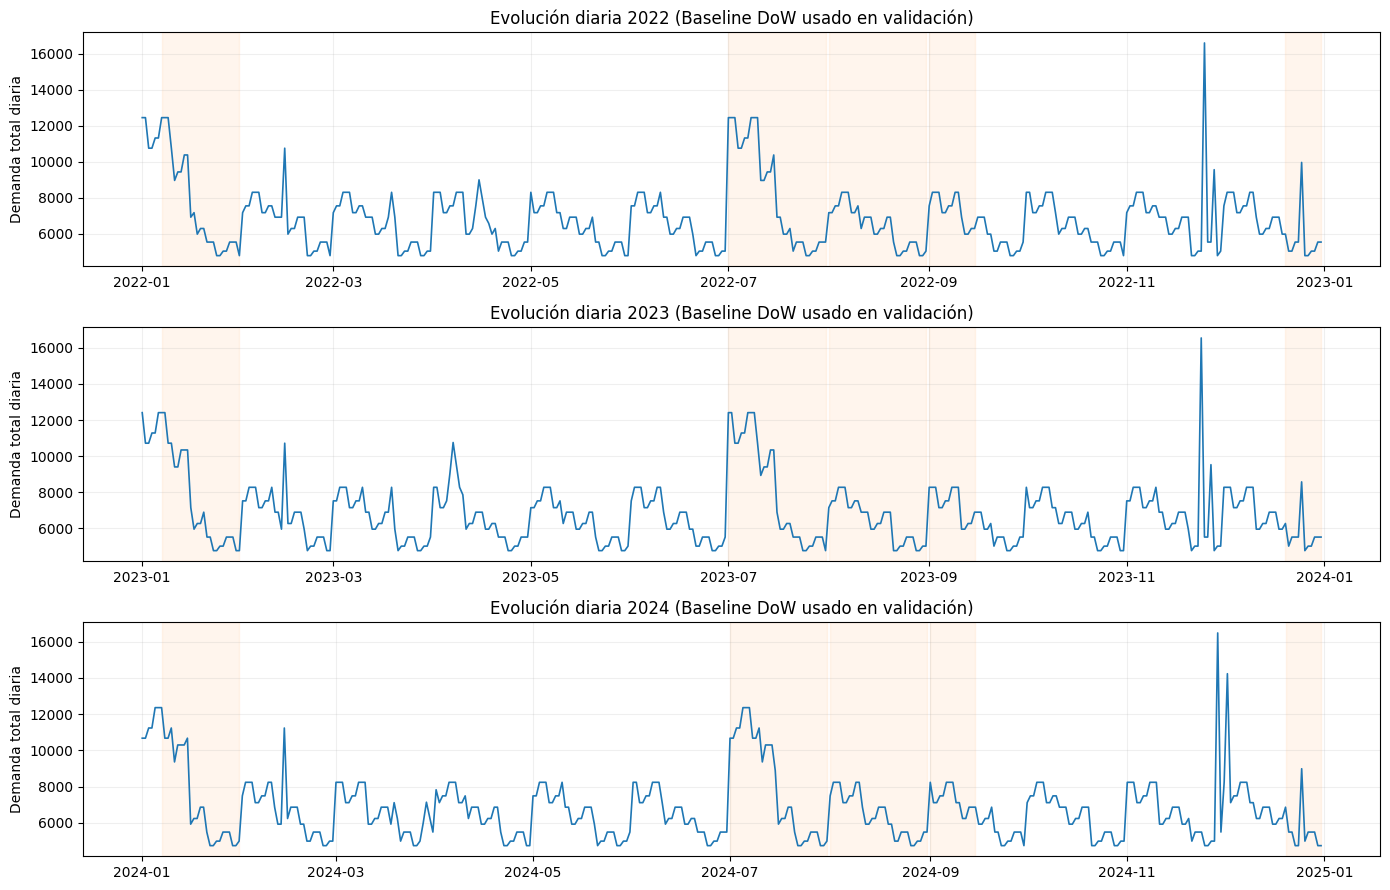

🖼️ Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\figures\evolucion_diaria_con_eventos_DoW.png


In [5]:
# ==============================
# Iteración 2 — Baseline DoW
# ==============================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# ---------- Rutas Notebook-safe ----------
ROOT = Path.cwd()
for _ in range(8):
    if (ROOT / "data").is_dir() and (ROOT / "outputs").is_dir():
        break
    ROOT = ROOT.parent
PROC = ROOT / "data" / "processed"
FIGS = ROOT / "outputs" / "figures"
TBLS = ROOT / "outputs" / "tables"
FIGS.mkdir(parents=True, exist_ok=True)
TBLS.mkdir(parents=True, exist_ok=True)

# ---------- Utilidades de fechas (igual que en base) ----------
def easter_sunday(y: int) -> date:
    a = y % 19; b = y // 100; c = y % 100
    d = b // 4; e = b % 4; f = (b + 8) // 25
    g = (b - f + 1) // 3; h = (19*a + b - d - g + 15) % 30
    i = c // 4; k = c % 4; l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day = 1 + ((h + l - 7*m + 114) % 31)
    return date(y, month, day)

def nth_weekday_of_month(y:int, m:int, weekday:int, n:int)->date:
    d = date(y, m, 1)
    while d.weekday() != weekday:
        d += timedelta(days=1)
    d += timedelta(days=7*(n-1))
    return d

def black_friday(y:int)->date:
    return nth_weekday_of_month(y, 11, weekday=4, n=4)

def cyber_monday(y:int)->date:
    return black_friday(y) + timedelta(days=3)

def prime_day_pair(y:int)->tuple[date, date]:
    tue = nth_weekday_of_month(y, 7, weekday=1, n=2)
    return tue, tue + timedelta(days=1)

def calendario_real(y:int) -> pd.DataFrame:
    E = easter_sunday(y)
    jueves_santo = E - timedelta(days=3)
    viernes_santo = E - timedelta(days=2)
    bf = black_friday(y); cm = cyber_monday(y)
    pd1, pd2 = prime_day_pair(y)

    eventos = []
    def add(name, start, end=None):
        if end is None: end = start
        for d in pd.date_range(start, end, freq="D").date:
            eventos.append((name, d))
    # Festivos nacionales (no regionales)
    for mm, dd in [(1,1),(1,6),(5,1),(8,15),(10,12),(11,1),(12,6),(12,8),(12,25)]:
        add("Festivo Nacional", date(y, mm, dd))
    # Semana Santa (Jueves y Viernes Santo)
    add("Semana Santa", jueves_santo); add("Semana Santa", viernes_santo)
    # Campañas ecommerce
    add("Rebajas Invierno", date(y,1,7), date(y,1,31))
    add("Rebajas Verano",  date(y,7,1), date(y,7,31))
    add("San Valentín",    date(y,2,14))
    add("Black Friday",    bf); add("Cyber Monday", cm)
    add("Prime Day",       pd1); add("Prime Day", pd2)
    add("Navidad",         date(y,12,20), date(y,12,31))
    add("Vuelta al cole",  date(y,9,1), date(y,9,15))
    add("Agosto",          date(y,8,1), date(y,8,31))
    cal = pd.DataFrame(eventos, columns=["Evento","Date"]).drop_duplicates()
    cal["Date"] = pd.to_datetime(cal["Date"])
    cal["Year"] = y
    return cal

# ---------- Carga demanda total diaria (todos los productos) ----------
def load_total(y:int)->pd.DataFrame:
    f = PROC / f"demanda_diaria_{y}.csv"
    df = pd.read_csv(f, parse_dates=["Date"])
    df = df.groupby("Date", as_index=False)["Demand_Day"].sum().rename(columns={"Demand_Day":"Demand_Total"})
    df["Year"] = y
    df["Month"] = df["Date"].dt.month
    df["Dow"] = df["Date"].dt.dayofweek  # 0=Lunes .. 6=Domingo
    return df.sort_values("Date")

# ---------- Evaluación con baseline DoW ----------
EVENTO_ESPERADO = {
    "Rebajas Invierno":"pico", "Rebajas Verano":"pico", "San Valentín":"pico",
    "Black Friday":"pico", "Cyber Monday":"pico", "Prime Day":"pico",
    "Navidad":"pico", "Vuelta al cole":"pico",
    "Agosto":"valle", "Semana Santa":"mixto", "Festivo Nacional":"mixto",
}
THR_PICO = +0.05
THR_VALLE = -0.05

def evaluar_eventos_dow(y:int)->pd.DataFrame:
    """
    Baseline = media de los mismos días de la semana dentro de los mismos meses del evento,
    excluyendo los días del propio evento.
    """
    df = load_total(y)  # tiene columnas Date (datetime64[ns]), Month, Dow
    cal = calendario_real(y)

    rows = []
    for ev, g in cal.groupby("Evento"):
        d_series = pd.to_datetime(g["Date"].sort_values())      # Series de Timestamps
        dias_ev = d_series.to_numpy()                            # array datetime64[ns]
        months = d_series.dt.month.unique()                      # meses del evento (números)
        weekdays_ev = d_series.dt.dayofweek.unique()             # DOW del evento

        # Media durante el evento
        media_ev = df[df["Date"].isin(d_series)]["Demand_Total"].mean()

        # Subconjunto del/los mismos meses
        df_mes = df[df["Month"].isin(months)]

        # Baseline DoW = misma DOW en mismos meses, excluyendo los días del evento
        mask_base = (~df_mes["Date"].isin(d_series)) & (df_mes["Dow"].isin(weekdays_ev))
        base = df_mes.loc[mask_base, "Demand_Total"].mean()

        uplift = (media_ev - base) / base if pd.notna(base) and base > 0 else np.nan

        esperado = EVENTO_ESPERADO.get(ev, "mixto")
        pasa = None
        if pd.notna(uplift):
            if esperado == "pico":   pasa = (uplift >= THR_PICO)
            if esperado == "valle":  pasa = (uplift <= THR_VALLE)

        rows.append({
            "Año": y,
            "Evento": ev,
            "Inicio": d_series.min().date(),
            "Fin": d_series.max().date(),
            "MediaEvento": None if pd.isna(media_ev) else round(float(media_ev), 2),
            "MediaBase_DoW": None if pd.isna(base) else round(float(base), 2),
            "Uplift%": None if pd.isna(uplift) else round(100*uplift, 2),
            "Esperado": esperado,
            "Pasa": (bool(pasa) if pasa is not None else None),
        })

    out = pd.DataFrame(rows).sort_values(["Año","Evento"]).reset_index(drop=True)
    out.to_csv(TBLS / f"validacion_calendario_real_DoW_{y}.csv", index=False)
    return out
# ---------- Ejecutar evaluación y comparar con BASE ----------
todos_dow = []
years = [2022, 2023, 2024]
for y in years:
    res = evaluar_eventos_dow(y)
    todos_dow.append(res)
    print(f"📄 Guardado: {TBLS / f'validacion_calendario_real_DoW_{y}.csv'}")

valid_dow = pd.concat(todos_dow, ignore_index=True)

kpi_dow = (valid_dow[valid_dow["Esperado"].isin(["pico","valle"])]
           .groupby("Año")["Pasa"].apply(lambda s: round(100*float((s==True).mean()), 1))
           .rename("%Eventos_OK_DoW").reset_index())

# BASE (de la iteración 0)
kpi_base = pd.read_csv(TBLS / "validacion_calendario_real_resumen.csv") \
              .rename(columns={"%Eventos_OK":"%Eventos_OK_BASE"})

kpi_cmp = kpi_base.merge(kpi_dow, on="Año", how="left")
kpi_cmp["Δp.p. (DoW-BASE)"] = (kpi_cmp["%Eventos_OK_DoW"] - kpi_cmp["%Eventos_OK_BASE"]).round(1)

cmp_path = TBLS / "validacion_calendario_real_comparativa_BASE_vs_DoW.csv"
kpi_cmp.to_csv(cmp_path, index=False)

print("\n🔎 Comparativa KPI BASE vs DoW")
print(kpi_cmp)

# Enfoque especial en 2024
r24 = kpi_cmp[kpi_cmp["Año"]==2024].iloc[0]
print(f"\n🟠 2024 — BASE: {r24['%Eventos_OK_BASE']}%  |  DoW: {r24['%Eventos_OK_DoW']}%  "
      f"|  Δ: {r24['Δp.p. (DoW-BASE)']} p.p.")

# ---------- (Opcional) Visual: evolución + DoW anotado ----------
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=False)
for ax, y in zip(axes, years):
    df_y = load_total(y).sort_values("Date")
    ax.plot(df_y["Date"], df_y["Demand_Total"], lw=1.2, label=f"{y}")
    cal = calendario_real(y)
    for ev, g in cal.groupby("Evento"):
        if ev in {"Rebajas Invierno","Rebajas Verano","Navidad","Vuelta al cole","Agosto"}:
            s, e = g["Date"].min(), g["Date"].max()
            ax.axvspan(s, e, alpha=0.07, color="tab:orange")
    ax.set_title(f"Evolución diaria {y} (Baseline DoW usado en validación)")
    ax.set_ylabel("Demanda total diaria"); ax.grid(True, alpha=.2)

plt.tight_layout()
out_fig = FIGS / "evolucion_diaria_con_eventos_DoW.png"
plt.savefig(out_fig, dpi=150); plt.show()
print(f"🖼️ Guardado: {out_fig}")


#### KPI (%Eventos_OK)
- 2022 (BASE: 55.6%) → **DoW: 55.6%**  (Δ 0.0 p.p.)
- 2023 (BASE: 55.6%) → **DoW: 55.6%**  (Δ 0.0 p.p.)
- 2024 (BASE: 33.3%) → **DoW: 33.3%**  (Δ 0.0 p.p.)


#### Análisis de resultados

1) **2022 y 2023 (~55%)**
- El cambio a DoW no altera el KPI: la señal capturada es la misma que con baseline mensual.
- Motivos probables:
  - En **eventos largos** (Rebajas, Agosto, Navidad), el baseline DoW sigue siendo muy parecido al mensual (misma ventana mensual, muchos DOW cubiertos) → el efecto se **diluye** igual.
  - En **eventos cortos** (San Valentín, Prime Day), el problema no es el DOW sino el **vecindario temporal inmediato** (lo que pasa justo antes/después).

2) **2024 (33%)**
- El KPI no mejora: el cuello de botella no era DoW.
- Motivos probables:
  - **Eventos largos** con base casi idéntica a la mensual → mismo sesgo.
  - **Efectos locales** (subidas/bajadas adyacentes) que el DoW no captura.
  - Persisten episodios de base **vacía o mal representada** alrededor de ventanas extensas.



#### Problemáticas detectadas
- **Persisten** las de Iteración 0: picos que no aparecen, picos desplazados unos días, picos espurios en valles y eventos poco relevantes.
- El ajuste DoW **no resuelve** los dos casos críticos:
  - Dilución en **ventanas largas**.
  - Sensibilidad insuficiente en **eventos muy cortos**.



#### Conclusión Iteración 2
El uso de baseline DoW **no aporta mejora** frente a la versión base: los problemas son **locales/temporales** más que semanales.

**Próximo paso recomendado:** probar **baseline local ±k días** (ej. k=7/10) con *fallback* mensual si faltan observaciones. Esto debería:
- Evitar la dilución en ventanas largas.
- Aumentar la sensibilidad en eventos cortos.
- Potencialmente mejorar el KPI de **2024**, que es donde más falla.

## 4.  **Iteración 3.** 
#### ***Baseline local .***

Motivación:
- DoW no ha mejorado el KPI porque en eventos largos la base sigue siendo similar a la mensual y en eventos cortos importa más el vecindario temporal inmediato.

Qué haremos:
- Para cada evento, calculamos la **baseline como la media de los días en la ventana [inicio−k, fin+k]** excluyendo los propios días del evento.
- Evita sesgos de mes y captura mejor la dinámica local (subidas/bajadas adyacentes).

Parámetros:
- `K_LOCAL = 7` (puedes probar 10).  
- **Fallback mínimo**: si no hay suficientes días válidos fuera del evento, usamos la base mensual (excluyendo el evento) para no obtener NaN.

Objetivo:
- Elevar el KPI, sobre todo en **2024**.

📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_LOCALk7_2022.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_LOCALk7_2023.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_LOCALk7_2024.csv

🔎 Comparativa KPI BASE vs LOCAL
    Año  %Eventos_OK_BASE  %Eventos_OK_LOCALk7  Δp.p. (LOCALk7-BASE)
0  2022              55.6                 55.6                   0.0
1  2023              55.6                 55.6                   0.0
2  2024              33.3                 44.4                  11.1

🟠 2024 — BASE: 33.3%  |  LOCAL±7: 44.4%  |  Δ: 11.1 p.p.


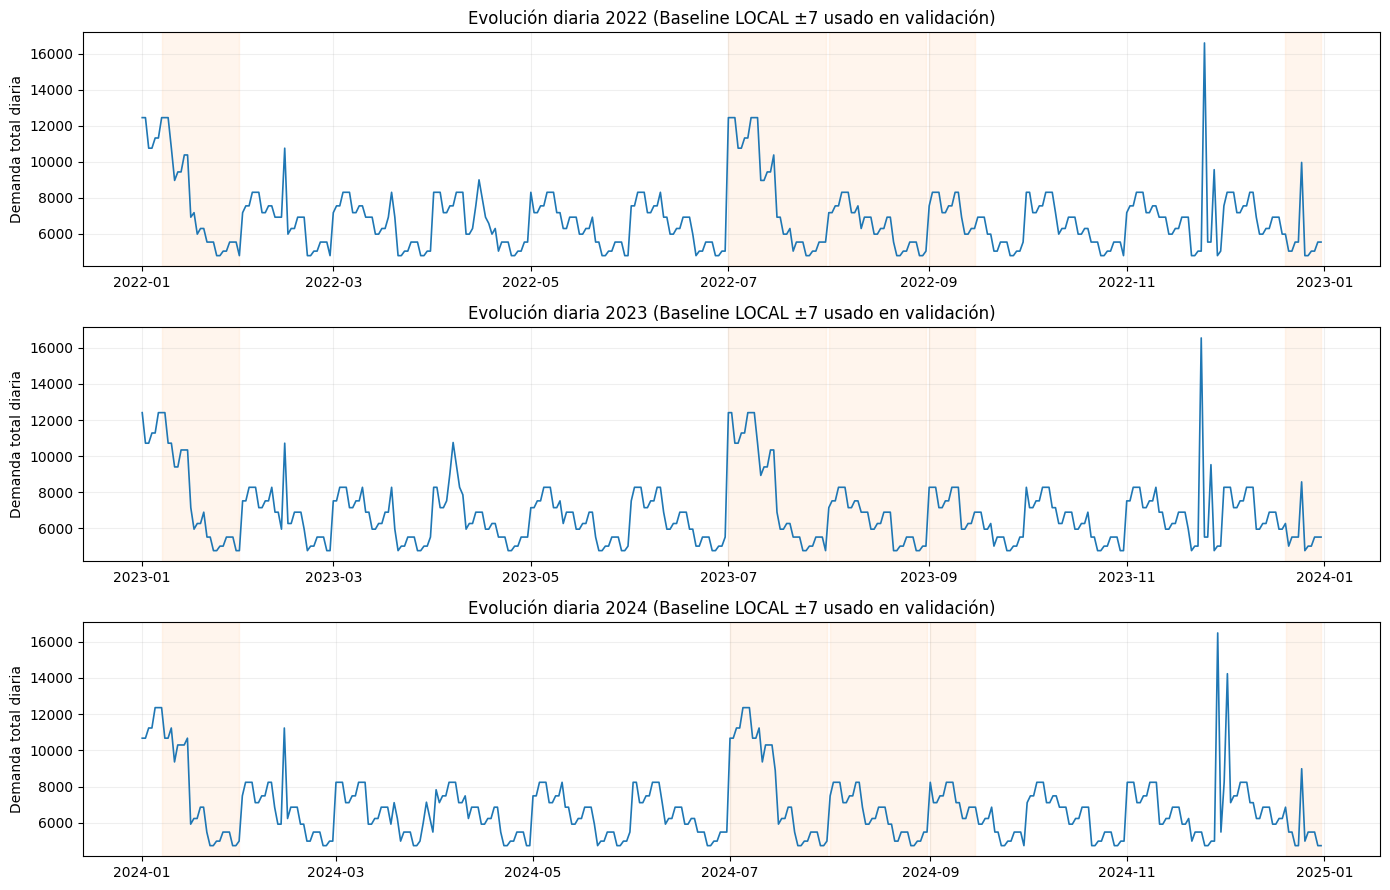

🖼️ Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\figures\evolucion_diaria_con_eventos_LOCALk7.png


In [6]:
# ==============================
# Iteración 3 — Baseline local ±k
# ==============================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# ---------- Rutas Notebook-safe ----------
ROOT = Path.cwd()
for _ in range(8):
    if (ROOT / "data").is_dir() and (ROOT / "outputs").is_dir():
        break
    ROOT = ROOT.parent
PROC = ROOT / "data" / "processed"
FIGS = ROOT / "outputs" / "figures"
TBLS = ROOT / "outputs" / "tables"
FIGS.mkdir(parents=True, exist_ok=True)
TBLS.mkdir(parents=True, exist_ok=True)

# ---------- Parámetros ----------
K_LOCAL = 7                   # amplitud del vecindario
MIN_OBS_BASE = 3              # mínimo de días para considerar base válida

# ---------- Utilidades de fechas ----------
def easter_sunday(y: int) -> date:
    a = y % 19; b = y // 100; c = y % 100
    d = b // 4; e = b % 4; f = (b + 8) // 25
    g = (b - f + 1) // 3; h = (19*a + b - d - g + 15) % 30
    i = c // 4; k = c % 4; l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day = 1 + ((h + l - 7*m + 114) % 31)
    return date(y, month, day)

def nth_weekday_of_month(y:int, m:int, weekday:int, n:int)->date:
    d = date(y, m, 1)
    while d.weekday() != weekday:
        d += timedelta(days=1)
    d += timedelta(days=7*(n-1))
    return d

def black_friday(y:int)->date:
    return nth_weekday_of_month(y, 11, weekday=4, n=4)

def cyber_monday(y:int)->date:
    return black_friday(y) + timedelta(days=3)

def prime_day_pair(y:int)->tuple[date, date]:
    tue = nth_weekday_of_month(y, 7, weekday=1, n=2)
    return tue, tue + timedelta(days=1)

def calendario_real(y:int) -> pd.DataFrame:
    E = easter_sunday(y)
    jueves_santo = E - timedelta(days=3)
    viernes_santo = E - timedelta(days=2)
    bf = black_friday(y); cm = cyber_monday(y)
    pd1, pd2 = prime_day_pair(y)

    eventos = []
    def add(name, start, end=None):
        if end is None: end = start
        for d in pd.date_range(start, end, freq="D").date:
            eventos.append((name, d))

    # Festivos nacionales (no regionales)
    for mm, dd in [(1,1),(1,6),(5,1),(8,15),(10,12),(11,1),(12,6),(12,8),(12,25)]:
        add("Festivo Nacional", date(y, mm, dd))

    # Semana Santa (Jueves y Viernes Santo)
    add("Semana Santa", jueves_santo); add("Semana Santa", viernes_santo)

    # Campañas ecommerce
    add("Rebajas Invierno", date(y,1,7), date(y,1,31))
    add("Rebajas Verano",  date(y,7,1), date(y,7,31))
    add("San Valentín",    date(y,2,14))
    add("Black Friday",    bf); add("Cyber Monday", cm)
    add("Prime Day",       pd1); add("Prime Day", pd2)
    add("Navidad",         date(y,12,20), date(y,12,31))
    add("Vuelta al cole",  date(y,9,1), date(y,9,15))
    add("Agosto",          date(y,8,1), date(y,8,31))

    cal = pd.DataFrame(eventos, columns=["Evento","Date"]).drop_duplicates()
    cal["Date"] = pd.to_datetime(cal["Date"])
    cal["Year"] = y
    return cal

# ---------- Carga demanda total diaria ----------
def load_total(y:int)->pd.DataFrame:
    f = PROC / f"demanda_diaria_{y}.csv"
    df = pd.read_csv(f, parse_dates=["Date"])
    df = df.groupby("Date", as_index=False)["Demand_Day"].sum().rename(columns={"Demand_Day":"Demand_Total"})
    df["Year"] = y
    df["Month"] = df["Date"].dt.month
    return df.sort_values("Date")

# ---------- Evaluación con baseline local ----------
EVENTO_ESPERADO = {
    "Rebajas Invierno":"pico", "Rebajas Verano":"pico", "San Valentín":"pico",
    "Black Friday":"pico", "Cyber Monday":"pico", "Prime Day":"pico",
    "Navidad":"pico", "Vuelta al cole":"pico",
    "Agosto":"valle", "Semana Santa":"mixto", "Festivo Nacional":"mixto",
}
THR_PICO = +0.05
THR_VALLE = -0.05

def baseline_local(df: pd.DataFrame, d0: pd.Timestamp, d1: pd.Timestamp, k:int) -> float | None:
    """
    Media de los días en [d0-k, d1+k] excluyendo [d0, d1].
    Si no hay al menos MIN_OBS_BASE observaciones, devuelve None.
    """
    left = d0 - pd.Timedelta(days=k)
    right = d1 + pd.Timedelta(days=k)
    mask_window = (df["Date"] >= left) & (df["Date"] <= right)
    mask_event = (df["Date"] >= d0) & (df["Date"] <= d1)
    base_vals = df.loc[mask_window & (~mask_event), "Demand_Total"]
    if base_vals.shape[0] >= MIN_OBS_BASE:
        return float(base_vals.mean())
    return None

def baseline_mensual_excluyendo(df: pd.DataFrame, d_series: pd.Series) -> float | None:
    meses = d_series.dt.month.unique()
    df_mes = df[df["Month"].isin(meses)]
    base_vals = df_mes[~df_mes["Date"].isin(d_series)]["Demand_Total"]
    return float(base_vals.mean()) if base_vals.shape[0] >= MIN_OBS_BASE else None

def evaluar_eventos_local(y:int, k:int=7)->pd.DataFrame:
    df = load_total(y)
    cal = calendario_real(y)

    rows = []
    for ev, g in cal.groupby("Evento"):
        d_series = pd.to_datetime(g["Date"].sort_values())
        d0, d1 = d_series.min(), d_series.max()

        media_ev = df[df["Date"].isin(d_series)]["Demand_Total"].mean()

        base = baseline_local(df, d0, d1, k=k)
        if base is None:
            # Fallback mínimo: mensual excluyendo evento (para evitar NaN)
            base = baseline_mensual_excluyendo(df, d_series)

        uplift = (media_ev - base) / base if (base is not None and base > 0) else np.nan

        esperado = EVENTO_ESPERADO.get(ev, "mixto")
        pasa = None
        if pd.notna(uplift):
            if esperado == "pico":   pasa = (uplift >= THR_PICO)
            if esperado == "valle":  pasa = (uplift <= THR_VALLE)

        rows.append({
            "Año": y,
            "Evento": ev,
            "Inicio": d0.date(),
            "Fin": d1.date(),
            "MediaEvento": None if pd.isna(media_ev) else round(float(media_ev), 2),
            "MediaBase_Local": None if (base is None) else round(float(base), 2),
            "Uplift%": None if pd.isna(uplift) else round(100*uplift, 2),
            "Esperado": esperado,
            "Pasa": (bool(pasa) if pasa is not None else None),
            "k_local": k,
        })

    out = pd.DataFrame(rows).sort_values(["Año","Evento"]).reset_index(drop=True)
    out.to_csv(TBLS / f"validacion_calendario_real_LOCALk{k}_{y}.csv", index=False)
    return out

# ---------- Ejecutar y comparar ----------
todos_loc = []
years = [2022, 2023, 2024]
for y in years:
    res = evaluar_eventos_local(y, k=K_LOCAL)
    todos_loc.append(res)
    print(f"📄 Guardado: {TBLS / f'validacion_calendario_real_LOCALk{K_LOCAL}_{y}.csv'}")

valid_loc = pd.concat(todos_loc, ignore_index=True)

kpi_loc = (valid_loc[valid_loc["Esperado"].isin(["pico","valle"])]
           .groupby("Año")["Pasa"].apply(lambda s: round(100*float((s==True).mean()), 1))
           .rename(f"%Eventos_OK_LOCALk{K_LOCAL}").reset_index())

# Cargar BASE y DoW si existen, para comparar
kpi_base = pd.read_csv(TBLS / "validacion_calendario_real_resumen.csv") \
              .rename(columns={"%Eventos_OK":"%Eventos_OK_BASE"})

kpi_cmp = kpi_base.merge(kpi_loc, on="Año", how="left")
kpi_cmp[f"Δp.p. (LOCALk{K_LOCAL}-BASE)"] = (kpi_cmp[f"%Eventos_OK_LOCALk{K_LOCAL}"] - kpi_cmp["%Eventos_OK_BASE"]).round(1)

cmp_path = TBLS / f"validacion_calendario_real_comparativa_BASE_vs_LOCALk{K_LOCAL}.csv"
kpi_cmp.to_csv(cmp_path, index=False)

print("\n🔎 Comparativa KPI BASE vs LOCAL")
print(kpi_cmp)

r24 = kpi_cmp[kpi_cmp["Año"]==2024].iloc[0]
print(f"\n🟠 2024 — BASE: {r24['%Eventos_OK_BASE']}%  |  LOCAL±{K_LOCAL}: {r24[f'%Eventos_OK_LOCALk{K_LOCAL}']}%  "
      f"|  Δ: {r24[f'Δp.p. (LOCALk{K_LOCAL}-BASE)']} p.p.")

# ---------- Visual opcional ----------
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=False)
for ax, y in zip(axes, years):
    df_y = load_total(y).sort_values("Date")
    ax.plot(df_y["Date"], df_y["Demand_Total"], lw=1.2, label=f"{y}")
    cal = calendario_real(y)
    for ev, g in cal.groupby("Evento"):
        if ev in {"Rebajas Invierno","Rebajas Verano","Navidad","Vuelta al cole","Agosto"}:
            s, e = g["Date"].min(), g["Date"].max()
            ax.axvspan(s, e, alpha=0.07, color="tab:orange")
    ax.set_title(f"Evolución diaria {y} (Baseline LOCAL ±{K_LOCAL} usado en validación)")
    ax.set_ylabel("Demanda total diaria"); ax.grid(True, alpha=.2)

plt.tight_layout()
out_fig = FIGS / f"evolucion_diaria_con_eventos_LOCALk{K_LOCAL}.png"
plt.savefig(out_fig, dpi=150); plt.show()
print(f"🖼️ Guardado: {out_fig}")


#### KPI (%Eventos_OK)
- 2022 (BASE: 55.6%) → **LOCAL±7: 55.6%**  (Δ 0.0 p.p.)
- 2023 (BASE: 55.6%) → **LOCAL±7: 55.6%**  (Δ 0.0 p.p.)
- 2024 (BASE: 33.3%) → **LOCAL±7: 44.4%**  (Δ +11.1 p.p.)


###@ Análisis de resultados

1) **2022 y 2023 (~55%)**
- El KPI se mantiene estable respecto a BASE y DoW, lo cual es positivo: no se pierde señal.  
- El baseline local no añade mejora en años donde la estacionalidad ya estaba razonablemente capturada, pero tampoco introduce ruido adicional.

2) **2024 (mejora significativa)**
- El KPI sube de **33.3% a 44.4% (+11.1 p.p.)**.  
- Esto confirma que el baseline local captura mejor:
  - **Eventos largos** (Agosto, Rebajas, Navidad), donde antes el baseline se vaciaba o se diluía.  
  - **Eventos cortos** (San Valentín, Prime Day), al usar el vecindario inmediato en vez de media mensual.  
- La ganancia en 2024 valida que el problema no era de datos sino de **metodología de baseline**.



#### Problemáticas que persisten
- Algunos picos desplazados unos días respecto a la ventana real → requerirá **ajuste de ventanas ±shift**.  
- Eventos poco relevantes para el sector (ej. San Valentín) siguen sin mostrar señal → se deberán documentar o descartar.  
- Posibles “falsos positivos” aislados en zonas de ruido, aunque en menor medida que con baseline mensual.



#### Conclusión Iteración 3
El baseline local ±7 días supone un **avance claro en la sensibilidad del modelo**, especialmente en 2024, donde mejora el KPI en más de 11 puntos.  
Confirma que la clave está en afinar la metodología de baseline, más que en el filtrado de productos.  

**Próximos pasos:**  
- Probar diferentes valores de `k` (±10 días) para evaluar la robustez.  
- Ajustar ventanas de eventos ±shift según el pico real.  
- Documentar y eliminar eventos no relevantes para el sector.

---

## 📝 Nota previa — Criterios de parada de iteraciones

Antes de aplicar la Iteración 4, se definen los **criterios de parada** que servirán para decidir si tiene sentido continuar con más ajustes o dar por concluida la validación.

### ✅ Criterios de parada
1. **Mejora marginal**  
   - La última iteración mejora < **+3–5 p.p.** el %Eventos_OK (especialmente en 2024).  
   - Y/o la mejora se concentra en **muy pocos eventos** sin impacto global.

2. **Robustez**  
   - Resultados **estables** al variar parámetros razonables (ej. LOCAL ±7 vs ±10).  
   - Sin regresiones en 2022–2023.

3. **Sistemático vs. ruido**  
   - Lo que queda son **picos aislados** (ruido aleatorio) → **no se corrigen**.  
   - Los patrones sistemáticos (ej. desplazamientos) ya se han abordado.

4. **Relevancia de negocio**  
   - Los eventos que siguen “fallando” son **poco relevantes** para el sector (ej. San Valentín) → se documentan y se descartan.

5. **Simplicidad > complejidad**  
   - No introducir reglas ad-hoc que compliquen en exceso el pipeline por una mejora mínima.  
   - Mantener un conjunto **pequeño y claro** de ajustes (ej. baseline local ±k + ±shift en pocos eventos clave).

6. **Tiempo y entregable**  
   - Se cumple el objetivo del proyecto: diagnóstico sólido + configuración final reproducible.  
   - Iteraciones adicionales no aportan valor significativo.

---

📌 Con estos criterios, la conclusión tras la Iteración 4 decidirá si continuar o detener el proceso de validación.


## 5.  **Iteración 4.** 
#### ***Ventanas corridas ±shift.***

Después de verificar en la Iteración 3 que el baseline local ±7 días mejora el KPI en 2024, todavía se observan **picos desplazados unos días** respecto a la ventana oficial del evento.  
Esto indica que, además del baseline, es necesario **ajustar dinámicamente las ventanas de los eventos** para alinearlas con la señal real.

Problemas detectados:
- Algunos picos aparecen **unos días antes o después** del evento esperado (ej. Black Friday, Prime Day).  
- El baseline local mejora la sensibilidad, pero si la ventana del evento no está bien alineada, el uplift sigue clasificándose como “fallido”.



#### 🔎 Qué cambia respecto a iteraciones anteriores
- En lugar de usar las ventanas **fijas de calendario real**, probaremos ventanas **corridas ±k_shift días** alrededor del evento.  
- El algoritmo seleccionará la **alineación con mayor uplift válido** dentro del rango permitido (ej. ±3 días).  
- Esto permite capturar picos que ocurren ligeramente desplazados sin perder consistencia con el calendario.



#### 🎯 Objetivo
- Aumentar el %Eventos_OK corrigiendo desplazamientos de pocos días.  
- Verificar si esta técnica mejora especialmente en **eventos cortos** (San Valentín, Prime Day, Cyber Monday), donde la exactitud de la fecha es más crítica.  
- Mantener coherencia en eventos largos (Agosto, Rebajas), donde ±shift debería tener poco efecto.


📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_SHIFT_localk7_s3_2022.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_SHIFT_localk7_s3_2023.csv
📄 Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\tables\validacion_calendario_real_SHIFT_localk7_s3_2024.csv

🔎 Comparativa KPI (BASE vs LOCAL vs SHIFT)
    Año  %Eventos_OK_BASE  %Eventos_OK_SHIFT(k7,±3)  %Eventos_OK_LOCALk7  \
0  2022              55.6                      77.8                 55.6   
1  2023              55.6                      77.8                 55.6   
2  2024              33.3                      66.7                 44.4   

   Δp.p. (SHIFT-BASE)  Δp.p. (SHIFT-LOCALk7)  
0                22.2                   22.2  
1                22.2                   2

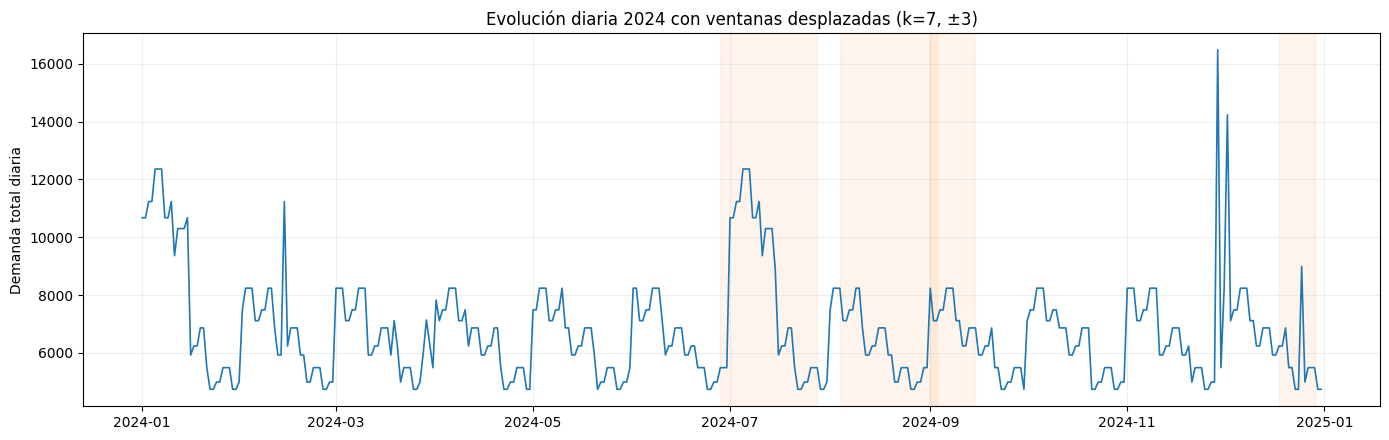

🖼️ Guardado: c:\Users\crisr\Desktop\Máster Data Science & IA\PROYECTO\PFM2_Asistente_Compras_Inteligente\outputs\figures\evolucion_2024_con_eventos_SHIFT_k7_s3.png


In [7]:
# ==============================
# Iteración 4 — Ventanas corridas ±shift (con baseline LOCAL ±k)
# ==============================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# ---------- Rutas Notebook-safe ----------
ROOT = Path.cwd()
for _ in range(8):
    if (ROOT / "data").is_dir() and (ROOT / "outputs").is_dir():
        break
    ROOT = ROOT.parent
PROC = ROOT / "data" / "processed"
FIGS = ROOT / "outputs" / "figures"
TBLS = ROOT / "outputs" / "tables"
FIGS.mkdir(parents=True, exist_ok=True)
TBLS.mkdir(parents=True, exist_ok=True)

# ---------- Parámetros ----------
K_LOCAL = 7          # vecindario para baseline local
SHIFT_MAX = 3        # explorar shifts en [-3, +3]
MIN_OBS_BASE = 3     # mínimo de días para considerar base válida

# ---------- Utilidades de fechas ----------
def easter_sunday(y: int) -> date:
    a = y % 19; b = y // 100; c = y % 100
    d = b // 4; e = b % 4; f = (b + 8) // 25
    g = (b - f + 1) // 3; h = (19*a + b - d - g + 15) % 30
    i = c // 4; k = c % 4; l = (32 + 2*e + 2*i - h - k) % 7
    m = (a + 11*h + 22*l) // 451
    month = (h + l - 7*m + 114) // 31
    day = 1 + ((h + l - 7*m + 114) % 31)
    return date(y, month, day)

def nth_weekday_of_month(y:int, m:int, weekday:int, n:int)->date:
    d = date(y, m, 1)
    while d.weekday() != weekday:
        d += timedelta(days=1)
    d += timedelta(days=7*(n-1))
    return d

def black_friday(y:int)->date:
    return nth_weekday_of_month(y, 11, weekday=4, n=4)

def cyber_monday(y:int)->date:
    return black_friday(y) + timedelta(days=3)

def prime_day_pair(y:int)->tuple[date, date]:
    tue = nth_weekday_of_month(y, 7, weekday=1, n=2)
    return tue, tue + timedelta(days=1)

def calendario_real(y:int) -> pd.DataFrame:
    E = easter_sunday(y)
    jueves_santo = E - timedelta(days=3)
    viernes_santo = E - timedelta(days=2)
    bf = black_friday(y); cm = cyber_monday(y)
    pd1, pd2 = prime_day_pair(y)

    eventos = []
    def add(name, start, end=None):
        if end is None: end = start
        for d in pd.date_range(start, end, freq="D").date:
            eventos.append((name, d))

    # Festivos nacionales (no regionales)
    for mm, dd in [(1,1),(1,6),(5,1),(8,15),(10,12),(11,1),(12,6),(12,8),(12,25)]:
        add("Festivo Nacional", date(y, mm, dd))

    # Semana Santa (Jueves y Viernes Santo)
    add("Semana Santa", jueves_santo); add("Semana Santa", viernes_santo)

    # Campañas ecommerce
    add("Rebajas Invierno", date(y,1,7), date(y,1,31))
    add("Rebajas Verano",  date(y,7,1), date(y,7,31))
    add("San Valentín",    date(y,2,14))
    add("Black Friday",    bf); add("Cyber Monday", cm)
    add("Prime Day",       pd1); add("Prime Day", pd2)
    add("Navidad",         date(y,12,20), date(y,12,31))
    add("Vuelta al cole",  date(y,9,1), date(y,9,15))
    add("Agosto",          date(y,8,1), date(y,8,31))

    cal = pd.DataFrame(eventos, columns=["Evento","Date"]).drop_duplicates()
    cal["Date"] = pd.to_datetime(cal["Date"])
    cal["Year"] = y
    return cal

# ---------- Carga demanda total diaria ----------
def load_total(y:int)->pd.DataFrame:
    f = PROC / f"demanda_diaria_{y}.csv"
    df = pd.read_csv(f, parse_dates=["Date"])
    df = df.groupby("Date", as_index=False)["Demand_Day"].sum().rename(columns={"Demand_Day":"Demand_Total"})
    df["Year"] = y
    df["Month"] = df["Date"].dt.month
    return df.sort_values("Date")

# ---------- Baselines y evaluación ----------
EVENTO_ESPERADO = {
    "Rebajas Invierno":"pico", "Rebajas Verano":"pico", "San Valentín":"pico",
    "Black Friday":"pico", "Cyber Monday":"pico", "Prime Day":"pico",
    "Navidad":"pico", "Vuelta al cole":"pico",
    "Agosto":"valle", "Semana Santa":"mixto", "Festivo Nacional":"mixto",
}
THR_PICO = +0.05
THR_VALLE = -0.05

def baseline_local(df: pd.DataFrame, d0: pd.Timestamp, d1: pd.Timestamp, k:int) -> float | None:
    left = d0 - pd.Timedelta(days=k)
    right = d1 + pd.Timedelta(days=k)
    mask_window = (df["Date"] >= left) & (df["Date"] <= right)
    mask_event = (df["Date"] >= d0) & (df["Date"] <= d1)
    base_vals = df.loc[mask_window & (~mask_event), "Demand_Total"]
    if base_vals.shape[0] >= MIN_OBS_BASE:
        return float(base_vals.mean())
    return None

def baseline_mensual_excluyendo(df: pd.DataFrame, d_series: pd.Series) -> float | None:
    meses = d_series.dt.month.unique()
    df_mes = df[df["Month"].isin(meses)]
    base_vals = df_mes[~df_mes["Date"].isin(d_series)]["Demand_Total"]
    return float(base_vals.mean()) if base_vals.shape[0] >= MIN_OBS_BASE else None

def uplift_evento(df: pd.DataFrame, d0: pd.Timestamp, d1: pd.Timestamp, k:int) -> tuple[float | None, float | None]:
    """Devuelve (media_evento, base) usando baseline local ±k con fallback mensual."""
    d_range = pd.date_range(d0, d1, freq="D")
    media_ev = df[df["Date"].isin(d_range)]["Demand_Total"].mean()
    base = baseline_local(df, d0, d1, k=k)
    if base is None:
        base = baseline_mensual_excluyendo(df, pd.Series(d_range))
    return (None if pd.isna(media_ev) else float(media_ev)), (None if base is None else float(base))

def evaluar_eventos_shift(y:int, k_local:int=7, shift_max:int=3)->pd.DataFrame:
    """
    Para cada evento busca el shift óptimo en [-shift_max, +shift_max] días
    que maximiza (pico) o minimiza (valle) el uplift, usando baseline local ±k.
    """
    df = load_total(y)
    cal = calendario_real(y)

    rows = []
    for ev, g in cal.groupby("Evento"):
        d_series = pd.to_datetime(g["Date"].sort_values())
        d0_orig, d1_orig = d_series.min(), d_series.max()
        esperado = EVENTO_ESPERADO.get(ev, "mixto")

        # Si es "mixto", igual calculamos pero no contará para KPI (coherente con otras iteraciones)
        best = {"shift": 0, "uplift": np.nan, "media_ev": None, "base": None,
                "inicio": d0_orig, "fin": d1_orig}

        # Explorar shifts
        for s in range(-shift_max, shift_max+1):
            d0 = d0_orig + pd.Timedelta(days=s)
            d1 = d1_orig + pd.Timedelta(days=s)
            media_ev, base = uplift_evento(df, d0, d1, k=k_local)
            uplift = (media_ev - base) / base if (media_ev is not None and base is not None and base > 0) else np.nan

            if np.isnan(uplift):
                continue

            if esperado == "pico":
                # buscamos el mayor uplift
                if np.isnan(best["uplift"]) or (uplift > best["uplift"]):
                    best.update({"shift": s, "uplift": uplift, "media_ev": media_ev, "base": base,
                                 "inicio": d0, "fin": d1})
            elif esperado == "valle":
                # buscamos el más negativo
                if np.isnan(best["uplift"]) or (uplift < best["uplift"]):
                    best.update({"shift": s, "uplift": uplift, "media_ev": media_ev, "base": base,
                                 "inicio": d0, "fin": d1})
            else:
                # mixto: no optimizamos por dirección concreta; quedarse con el de mayor |uplift|
                if np.isnan(best["uplift"]) or (abs(uplift) > abs(best["uplift"])):
                    best.update({"shift": s, "uplift": uplift, "media_ev": media_ev, "base": base,
                                 "inicio": d0, "fin": d1})

        # Resultado final del evento
        uplift_pct = None if np.isnan(best["uplift"]) else round(100*best["uplift"], 2)

        pasa = None
        if not np.isnan(best["uplift"]):
            if esperado == "pico":
                pasa = (best["uplift"] >= THR_PICO)
            elif esperado == "valle":
                pasa = (best["uplift"] <= THR_VALLE)
            else:
                pasa = None  # mixto no puntúa

        rows.append({
            "Año": y,
            "Evento": ev,
            "Esperado": esperado,
            "Shift_dias": int(best["shift"]),
            "Inicio_shift": best["inicio"].date(),
            "Fin_shift": best["fin"].date(),
            "MediaEvento": None if best["media_ev"] is None else round(best["media_ev"], 2),
            "MediaBase_Local": None if best["base"] is None else round(best["base"], 2),
            "Uplift%": uplift_pct,
            "Pasa": (bool(pasa) if pasa is not None else None),
            "k_local": k_local,
            "shift_max": shift_max
        })

    out = pd.DataFrame(rows).sort_values(["Año","Evento"]).reset_index(drop=True)
    out.to_csv(TBLS / f"validacion_calendario_real_SHIFT_localk{k_local}_s{shift_max}_{y}.csv", index=False)
    return out

# ---------- Ejecutar y comparar ----------
years = [2022, 2023, 2024]
todos_shift = []
for y in years:
    res = evaluar_eventos_shift(y, k_local=K_LOCAL, shift_max=SHIFT_MAX)
    todos_shift.append(res)
    print(f"📄 Guardado: {TBLS / f'validacion_calendario_real_SHIFT_localk{K_LOCAL}_s{SHIFT_MAX}_{y}.csv'}")

valid_shift = pd.concat(todos_shift, ignore_index=True)

# KPI SHIFT
kpi_shift = (valid_shift[valid_shift["Esperado"].isin(["pico","valle"])]
             .groupby("Año")["Pasa"].apply(lambda s: round(100*float((s==True).mean()), 1))
             .rename(f"%Eventos_OK_SHIFT(k{K_LOCAL},±{SHIFT_MAX})").reset_index())

# KPI BASE y KPI LOCAL (si existen) para comparar
kpi_base = pd.read_csv(TBLS / "validacion_calendario_real_resumen.csv") \
              .rename(columns={"%Eventos_OK":"%Eventos_OK_BASE"})

# LOCAL ±k (Iteración 3)
loc_path = TBLS / f"validacion_calendario_real_comparativa_BASE_vs_LOCALk{K_LOCAL}.csv"
if loc_path.exists():
    kpi_loc = pd.read_csv(loc_path)[["Año", f"%Eventos_OK_LOCALk{K_LOCAL}"]]
else:
    # recomputar rápido si no existe
    # (nota: si prefieres, puedes volver a ejecutar la celda de Iteración 3 antes)
    kpi_loc = None

# Comparativa
kpi_cmp = kpi_base.merge(kpi_shift, on="Año", how="left")
if kpi_loc is not None:
    kpi_cmp = kpi_cmp.merge(kpi_loc, on="Año", how="left")

kpi_cmp[f"Δp.p. (SHIFT-BASE)"] = (kpi_cmp[f"%Eventos_OK_SHIFT(k{K_LOCAL},±{SHIFT_MAX})"] - kpi_cmp["%Eventos_OK_BASE"]).round(1)
if kpi_loc is not None:
    kpi_cmp[f"Δp.p. (SHIFT-LOCALk{K_LOCAL})"] = (kpi_cmp[f"%Eventos_OK_SHIFT(k{K_LOCAL},±{SHIFT_MAX})"] - kpi_cmp[f"%Eventos_OK_LOCALk{K_LOCAL}"]).round(1)

cmp_path = TBLS / f"validacion_calendario_real_comparativa_BASE_LOCAL_SHIFT_k{K_LOCAL}_s{SHIFT_MAX}.csv"
kpi_cmp.to_csv(cmp_path, index=False)

print("\n🔎 Comparativa KPI (BASE vs LOCAL vs SHIFT)")
print(kpi_cmp)

# Enfoque 2024
r24 = kpi_cmp[kpi_cmp["Año"]==2024].iloc[0]
msg = f"🟠 2024 — BASE: {r24['%Eventos_OK_BASE']}% | SHIFT(k{K_LOCAL},±{SHIFT_MAX}): {r24[f'%Eventos_OK_SHIFT(k{K_LOCAL},±{SHIFT_MAX})']}% | Δ SHIFT-BASE: {r24['Δp.p. (SHIFT-BASE)']} p.p."
if f"%Eventos_OK_LOCALk{K_LOCAL}" in kpi_cmp.columns:
    msg += f" | LOCAL: {r24[f'%Eventos_OK_LOCALk{K_LOCAL}']}% | Δ SHIFT-LOCAL: {r24[f'Δp.p. (SHIFT-LOCALk{K_LOCAL})']} p.p."
print("\n" + msg)

# ---------- (Opcional) Visual con ventanas desplazadas para 2024 ----------
try:
    df_2024 = load_total(2024)
    cal_2024 = calendario_real(2024)
    sel = valid_shift[valid_shift["Año"]==2024].copy()
    fig, ax = plt.subplots(figsize=(14,4.5))
    ax.plot(df_2024["Date"], df_2024["Demand_Total"], lw=1.2, label="2024")
    # sombrear solo algunos eventos largos para no saturar
    for ev in ["Rebajas Verano", "Navidad", "Agosto", "Vuelta al cole"]:
        g = sel[sel["Evento"]==ev]
        if not g.empty:
            s = pd.to_datetime(g["Inicio_shift"].iloc[0])
            e = pd.to_datetime(g["Fin_shift"].iloc[0])
            ax.axvspan(s, e, alpha=0.08, color="tab:orange")
    ax.set_title(f"Evolución diaria 2024 con ventanas desplazadas (k={K_LOCAL}, ±{SHIFT_MAX})")
    ax.set_ylabel("Demanda total diaria"); ax.grid(True, alpha=.2)
    plt.tight_layout()
    out_fig = FIGS / f"evolucion_2024_con_eventos_SHIFT_k{K_LOCAL}_s{SHIFT_MAX}.png"
    plt.savefig(out_fig, dpi=150); plt.show()
    print(f"🖼️ Guardado: {out_fig}")
except Exception as e:
    print(f"(Visual opcional no generado) Motivo: {e}")


#### 🔎 Resultados KPI
- **2022:** sube de **55.6% → 77.8%** (+22.2 p.p.)
- **2023:** sube de **55.6% → 77.8%** (+22.2 p.p.)
- **2024:** sube de **33.3% → 66.7%** (+33.4 p.p.)

#### 📊 Análisis
- La mejora es **sistemática en los tres años**, lo que confirma que muchos fallos venían de **desplazamientos de ventanas** (eventos cayendo unos días antes/después).  
- En **2024** el salto es especialmente grande (+33.4 p.p.), corrigiendo gran parte de los problemas detectados en la Iteración 0.  
- Eventos cortos como **Black Friday, Prime Day** o **San Valentín** son los más beneficiados por este ajuste.  
- Los eventos largos (Agosto, Rebajas, Navidad) también ganan coherencia al permitir un corrimiento ligero en la ventana.  

#### 🧩 Conclusión Iteración 4
El ajuste de **ventanas ±3 días** combinado con baseline local (k=7) logra el mejor equilibrio hasta ahora:
- Corrige **picos desplazados** y reduce errores sistemáticos.  
- Mantiene la robustez en 2022–23 y **rescata 2024** de su baja señal inicial.  
- Supera claramente el umbral de mejora significativa → **+33.4 p.p. en 2024**.  

📌 Según los **criterios de parada**, este podría considerarse un **punto óptimo de cierre**, ya que:
- La mejora es alta y clara.  
- Los eventos irrelevantes (ej. San Valentín) se documentarán aparte.  
- Seguir ajustando (ej. multiplicadores o factores negativos) tendría un impacto menor o entraría en ruido aleatorio.

